In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({ 'font.size': 20, 'text.usetex': True })

import numpy as np
import tensorflow as tf

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from datetime import datetime

In [2]:
X, y = make_moons( n_samples = 100000, noise = 0.1, random_state = 123 )
trainX, testX, trainY, testY = train_test_split(X, y, test_size = 0.2 )

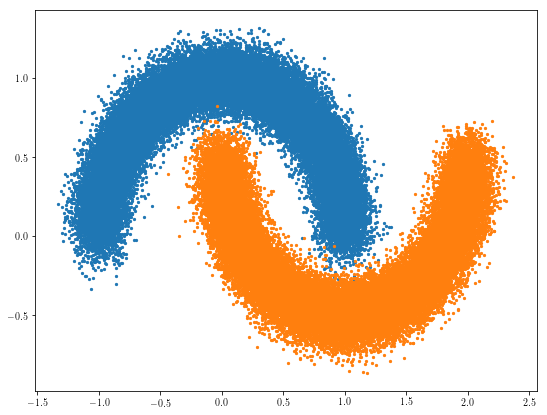

In [3]:
class1 = trainY == 0
class2 = trainY == 1

plt.figure( 1, (9, 7) )

plt.scatter( trainX[class1,0], trainX[class1,1], s = 5 )
plt.scatter( trainX[class2,0], trainX[class2,1], s = 5 )

plt.show()

In [4]:
def genBatch( X, y, batchSize ):
    """Generator of batches."""

    inds = np.random.permutation( len(X) )

    for start in range(0, len(X) - 1, batchSize):
            
        batchX = X[ inds[start : start + batchSize] ]
        batchY = y[ inds[start : start + batchSize] ]

        yield (batchX, batchY.reshape(len(batchY), 1))


In [5]:
alpha = 0.01
momentum = 0.9

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
rootLogDir = "tfLogs"
logDir = f"{rootLogDir}/run-{now}/"

fileWriter = tf.summary.FileWriter( logDir, tf.get_default_graph() )

In [6]:
sess = tf.Session()

def logRegPlus( X, y, hn = 10, alpha = 0.01, momentum = 0.9 ):

    n = int(X.get_shape()[1])

    with tf.name_scope("logRegPlus"):
        with tf.name_scope("model"):

            with tf.name_scope("hidden"):
                w     = tf.Variable( tf.random_uniform([n, hn], -1.0, 1.0), name = "w" )
                bias1 = tf.Variable( tf.zeros([hn]), name = "bias1" )
                layer1 = tf.nn.elu( tf.matmul(X, w) + bias1 )

            with tf.name_scope("output"):
                theta = tf.Variable( tf.random_uniform([hn, 1], -1.0, 1.0), name = "theta" )
                bias2  = tf.Variable( initial_value = 0.0, name = "bias2" )

                logits = tf.matmul(layer1, theta) + bias2
                probs  = tf.sigmoid( logits, name = "probabilities" )

        with tf.name_scope("train"):
            
            loss = tf.losses.log_loss( y, probs)

            opt = tf.train.MomentumOptimizer( learning_rate = alpha, momentum = momentum)
            training = opt.minimize( loss, var_list = [theta, bias1, w, bias2] )

            lossSummary = tf.summary.scalar("logLoss", loss)

        with tf.name_scope("init"):
            init = tf.global_variables_initializer()

        with tf.name_scope("save"):
            saver = tf.train.Saver()

    return probs, loss, training, lossSummary, init, saver

In [7]:
nEpochs   = 1000
batchSize = 108
nBatches  = int(np.ceil( len(trainX) / batchSize ) )

X = tf.placeholder(tf.float32, shape=(None, 2), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

probs, loss, training, lossSummary, init, saver = logRegPlus( X, y )

with tf.Session() as sess:
    
    step = 0

    sess.run(init)
    
    for epoch in range(nEpochs):
        for batchX, batchY in genBatch( trainX, trainY, batchSize ):

            if ( step % 10 == 0 ):
                sumStr = lossSummary.eval( feed_dict = {X : batchX, y : batchY} )
                fileWriter.add_summary( sumStr, step )

            sess.run( training, feed_dict = {X: batchX, y: batchY} )
            
            step += 1

        if epoch % 100 == 0:
            lossVal = loss.eval({X: trainX, y: trainY.reshape(len(trainY),1) })
            print(f"Epoch: {epoch}, Loss: {lossVal}")
            
    saver.save(sess, "./model")

    testProbs = probs.eval( feed_dict = {X: testX, y: testY.reshape(len(testY),1)} )


Epoch: 0, Loss: 0.2508074641227722
Epoch: 100, Loss: 0.0034740783739835024
Epoch: 200, Loss: 0.003076316323131323
Epoch: 300, Loss: 0.002951327245682478
Epoch: 400, Loss: 0.0028973696753382683
Epoch: 500, Loss: 0.0028517884202301502
Epoch: 600, Loss: 0.0028181015513837337
Epoch: 700, Loss: 0.002804066054522991
Epoch: 800, Loss: 0.002739644143730402
Epoch: 900, Loss: 0.0026975495275110006


In [8]:
testPred = testProbs.reshape(len(testY)) >= 0.5
np.sum( testPred == testY ) / len(testY)

0.99905